In [ ]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution2.csv')


In [2]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  43800 non-null  float64
 1   dew        43800 non-null  int64  
 2   temp       43800 non-null  float64
 3   press      43800 non-null  float64
 4   wnd_dir    43800 non-null  object 
 5   wnd_spd    43800 non-null  float64
 6   snow       43800 non-null  int64  
 7   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


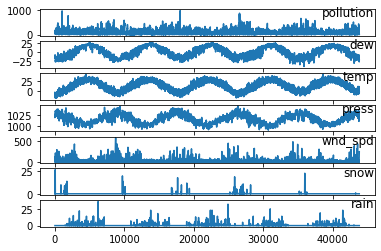

In [1]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

### Multivariate LSTM Forecast Model

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  
(35040, 1, 8) (35040,) (8759, 1, 8) (8759,)
Epoch 1/100
1095/1095 - 4s - loss: 0.0302 - val_loss: 0.0332 - 4s/epoch - 4ms/step
Epoch 2/100
1095/1095 - 2s - loss: 0.0144 - val_loss: 0.0226 - 2s/epoch - 2ms/step
Epoch 3/100
1095/1095 - 2s - loss: 0.0141 - val_loss: 0.0186 - 2s/epoch - 2ms/step
Epoch 4/100
1095/1095 - 2s - loss: 0.0140 - val_loss: 0.0181 - 2

Epoch 91/100
1095/1095 - 3s - loss: 0.0135 - val_loss: 0.0145 - 3s/epoch - 2ms/step
Epoch 92/100
1095/1095 - 2s - loss: 0.0135 - val_loss: 0.0145 - 2s/epoch - 2ms/step
Epoch 93/100
1095/1095 - 2s - loss: 0.0135 - val_loss: 0.0145 - 2s/epoch - 2ms/step
Epoch 94/100
1095/1095 - 3s - loss: 0.0135 - val_loss: 0.0143 - 3s/epoch - 2ms/step
Epoch 95/100
1095/1095 - 2s - loss: 0.0135 - val_loss: 0.0145 - 2s/epoch - 2ms/step
Epoch 96/100
1095/1095 - 2s - loss: 0.0134 - val_loss: 0.0146 - 2s/epoch - 2ms/step
Epoch 97/100
1095/1095 - 2s - loss: 0.0134 - val_loss: 0.0144 - 2s/epoch - 2ms/step
Epoch 98/100
1095/1095 - 2s - loss: 0.0134 - val_loss: 0.0144 - 2s/epoch - 2ms/step
Epoch 99/100
1095/1095 - 2s - loss: 0.0134 - val_loss: 0.0142 - 2s/epoch - 2ms/step
Epoch 100/100
1095/1095 - 2s - loss: 0.0134 - val_loss: 0.0143 - 2s/epoch - 2ms/step


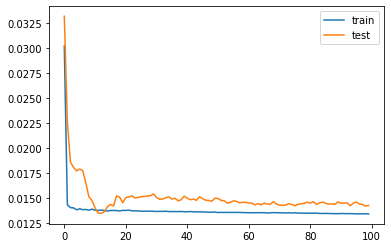

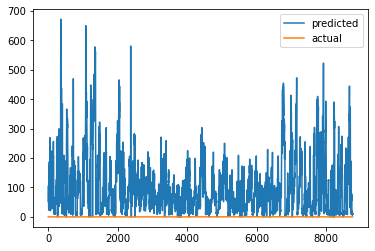

Test RMSE: 25.636


In [3]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
values = reframed.values
# n_train_hours = 365 * 24
n_train_hours = 4 * 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(25, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

pyplot.plot(inv_y, label='predicted')
pyplot.plot(test_y, label='actual')
pyplot.legend()
pyplot.show()

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

### Train on multiple Lag Timesteps Example

(43797, 32)
The train shape is (26280, 32)
The test shape is (17517, 32)
(26280, 24) 26280 (26280,)
(26280, 3, 8) (26280,) (17517, 3, 8) (17517,)
Epoch 1/50
365/365 - 10s - loss: 0.0321 - val_loss: 0.0236 - 10s/epoch - 27ms/step
Epoch 2/50
365/365 - 2s - loss: 0.0195 - val_loss: 0.0238 - 2s/epoch - 5ms/step
Epoch 3/50
365/365 - 2s - loss: 0.0184 - val_loss: 0.0204 - 2s/epoch - 5ms/step
Epoch 4/50
365/365 - 2s - loss: 0.0171 - val_loss: 0.0190 - 2s/epoch - 5ms/step
Epoch 5/50
365/365 - 2s - loss: 0.0160 - val_loss: 0.0172 - 2s/epoch - 5ms/step
Epoch 6/50
365/365 - 2s - loss: 0.0151 - val_loss: 0.0158 - 2s/epoch - 5ms/step
Epoch 7/50
365/365 - 2s - loss: 0.0144 - val_loss: 0.0154 - 2s/epoch - 5ms/step
Epoch 8/50
365/365 - 2s - loss: 0.0141 - val_loss: 0.0152 - 2s/epoch - 4ms/step
Epoch 9/50
365/365 - 2s - loss: 0.0139 - val_loss: 0.0150 - 2s/epoch - 5ms/step
Epoch 10/50
365/365 - 2s - loss: 0.0138 - val_loss: 0.0147 - 2s/epoch - 5ms/step
Epoch 11/50
365/365 - 2s - loss: 0.0138 - val_loss

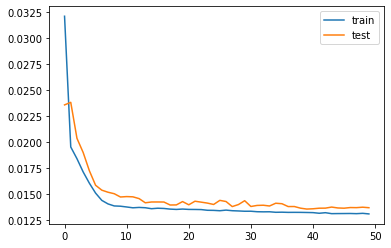

Test RMSE: 27.019


In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)
 
# split into train and test sets
values = reframed.values
n_train_hours = 3 * 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
print(f'The train shape is {train.shape}')
print(f'The test shape is {test.shape}')
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [9]:
yhat.shape

(17517, 1)

In [6]:
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [7]:
test_X.shape

(17517, 24)